# Predicting West Nile Virus in Chicago
Kaggle Overview Description: [Link](url_here)

### Notebook Contents:
<a href='#O'>Objective</a> <br>
<a href='#DS'>Data Summary</a> <br>
<a href='#DC'>Data Cleaning</a> <br>
<a href='#E'>Exploratory Data Analysis</a> <br>
<a href='#M'>Modeling</a> <br>

<a id='O'></a>

### Objective:

Predict the probability when and where different mosquitos will test positive for West Nile virus

<a id='DS'></a>

### Data Summary:

* Chicago Weather (2007 - 2014)
* West Nile Virus Testing (2007 - 2014) - odd years training data; even years testing data
* Mosquito Spraying (2011 - 2013)
<br>


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
#Load Data
#GIS data of spraying efforts in 2011 - 2013
df_spray = pd.read_csv('./WNV/spray.csv')

#the training and test set of the main dataset. The training set consists of data from 2007,
#2009, 2011, and 2013, while in the test set you are requested to predict the test results for 2008,
#2010, 2012, and 2014.
df_test = pd.read_csv('./WNV/test.csv')
df_train = pd.read_csv('./WNV/train.csv')

#weather data from 2007 to 2014. Column descriptions in noaa_weather_qclcd_documentation.pdf. 
df_weather = pd.read_csv('./WNV/weather.csv')

<a id='DC'></a>

### Data Cleaning:

In [4]:
#convert date object to datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

In [5]:
# drop useless columns first
df_weather = df_weather.drop(['Water1', 'SnowFall'], axis=1)
df_weather['PrecipTotal'].replace(to_replace = '  T',value = '0.00', inplace=True)

def split_station(weather_data, station_num):
    """
    Split weather.csv into a pd.dataframe
    Create a dataframe by df['Station']
    
    Parameters
    ----------
    weather_data : DataFrame

    station_num : int
    """
    st = weather_data[weather_data['Station']==station_num]
    st = st.reset_index()
    st = st.drop(['Station', 'index'], axis=1)
    
    return st

st_1 = split_station(df_weather, 1)
st_2 = split_station(df_weather, 2)

In [6]:
def codesum_columns(dataframe):
    """
    add codesum columns to a dataframe
    
    Parameters
    ----------
    dataframe : DataFrame
    """
    # get all values inside Codesum in st_1 ('BR', 'FG+', 'TSRA' etc..)
    codesum = dataframe['CodeSum'].value_counts().index.drop(' ')

    split_codesum = []
    all_conditions = []
    for i in codesum:

        # split 'TSRA RA BR HZ' into TSRA RA BR HZ
        element = i.split(' ')

        # add to a list. ['TSRA', 'RA', 'BR', HZ], ['TS', 'TSRA'], etc
        split_codesum.append(element)

    # list of all elements
    for item in split_codesum:
        for element in item:
            all_conditions.append(element)

    # remove all duplicates
    all_conditions = list(set(all_conditions))

    for colname in all_conditions:
        dataframe[colname] = 0

        # check if the exact string is in the Codesum column and if it is put 1 in the right column
        dataframe[colname] = dataframe['CodeSum'].str.contains(r'\b' + colname + r'\b').astype(int)

codesum_columns(st_1)
codesum_columns(st_2)

In [7]:
# rename each dataframe's column except 'Date'
for i in range(1, len(st_1.columns)):
    st_1.rename(columns={str(st_1.columns[i]) : str(st_1.columns[i]) + '_1'}, inplace=True)
for i in range(1, len(st_2.columns)):
    st_2.rename(columns={str(st_2.columns[i]) : str(st_2.columns[i]) + '_2'}, inplace=True)

In [8]:
#shift weather (num) days in future
def shift_weather(dataframe, num):
    weather_shifts = [f for f in dataframe if f != 'Date']
    dataframe[weather_shifts] = dataframe[weather_shifts].shift(num)
    dataframe.fillna(method='bfill', inplace=True)

shift_weather(st_1, 0)
shift_weather(st_2, 0)

In [9]:
# merge weather data into a dataset
def weather_merge(df, station_1, station_2):
    df_with_st_1 = pd.merge(df, station_1, on='Date')
    df_with_weather = pd.merge(df_with_st_1, station_2, on='Date')
    df_with_weather = df_with_weather.drop(['CodeSum_1', 'CodeSum_2'], axis=1)
    
    return df_with_weather

df_train = weather_merge(df_train, st_1, st_2)
df_test = weather_merge(df_test, st_1, st_2)

In [10]:
#bootstrapping the data
train_wnv = df_train.loc[df_train['WnvPresent']==1]
bootstrap = train_wnv.sample(n = 9404, replace=True)
df_train = pd.concat([df_train,bootstrap])
print(df_train['WnvPresent'].value_counts())
print(df_train['WnvPresent'].value_counts(normalize=True))

1    9955
0    9955
Name: WnvPresent, dtype: int64
1    0.5
0    0.5
Name: WnvPresent, dtype: float64


In [11]:
#set index to datetime
df_train.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)

#create columns for Month, Year & Day
df_train['Month'] = df_train.index.map(lambda x: x.month)
df_train['Year'] = df_train.index.map(lambda x: x.year)
df_train['Day'] = df_train.index.map(lambda x: x.day)

df_test['Month'] = df_test.index.map(lambda x: x.month)
df_test['Year'] = df_test.index.map(lambda x: x.year)
df_test['Day'] = df_test.index.map(lambda x: x.day)

In [12]:
def count_drop_m(df):
    for i in df.columns:
        if df[i].dtypes == 'object':
            if df[df[i] != 'M'].shape[0] == 0:
                    df.drop(i, axis=1, inplace=True)
                    print(i, "is dropped")
            
            elif 'M' in list(df[i].values):
                print(i, 'has', df[i].value_counts()['M'], 'M\'s')
                df.drop(labels=df[i].loc[df[i] == 'M'].index, axis=0, inplace=True)
    return df

df_train = count_drop_m(df_train)
df_test = count_drop_m(df_test)

WetBulb_1 has 93 M's
Depart_2 is dropped
Depth_2 is dropped
PrecipTotal_2 has 46 M's
Depart_2 is dropped
Depth_2 is dropped


In [13]:
df_train = df_train.drop(['Address', 'AddressNumberAndStreet','SQ_1', 'MIFG_1', 'SN_1',
                          'BCFG_1', 'FU_1', 'VCFG_2', 'SQ_2','SN_2', 'BCFG_2', 'GR_2',
                          'FU_2', 'NumMosquitos', 'Depth_1', 'Sunrise_2','Sunset_2'], axis = 1)
df_test = df_test.drop(['Address', 'AddressNumberAndStreet','SQ_1', 'MIFG_1', 'SN_1',
                        'BCFG_1', 'FU_1', 'VCFG_2', 'SQ_2','SN_2', 'BCFG_2', 'GR_2',
                        'FU_2', 'Depth_1', 'Sunrise_2','Sunset_2'], axis = 1)

In [14]:
def col_to_float(df):
    for i in df.columns:
        if df[i].dtypes == 'object':
            try:
                df[i] = df[i].astype(float)
            except:
                pass
            
col_to_float(df_train)
col_to_float(df_test)

In [15]:
def rolling(df, num):
    for i in df.columns:
        if df[i].dtypes != 'object':
            try: 
                df[i + '_rolling'] = df[i].rolling(num).mean().fillna(method='bfill')
            except:
                pass
            
rolling(df_train, 7)
rolling(df_test, 7)
        
df_train = df_train.drop(['Longitude_rolling', 'Latitude_rolling', 'WnvPresent_rolling'], axis = 1)
df_test = df_test.drop(['Longitude_rolling','Latitude_rolling'], axis = 1)   


<a id='E'></a>

### EDA:

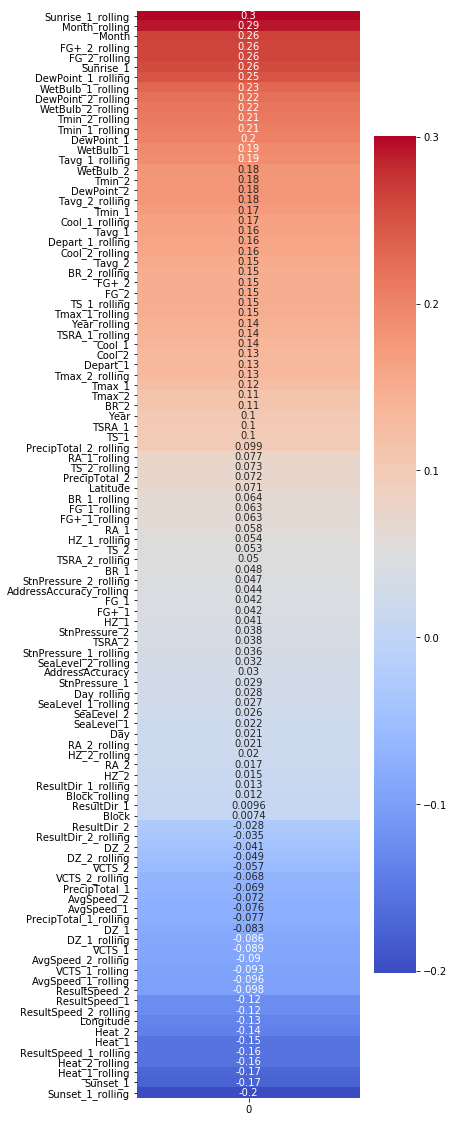

In [16]:
#Numeric Feature correlation with West Nile virus
corr_col = df_train.corrwith(df_train['WnvPresent']).sort_values(ascending=False)[1:].to_frame()
fig, ax = plt.subplots(figsize=(5,20))
sns.heatmap(corr_col, cmap='coolwarm', annot=True);

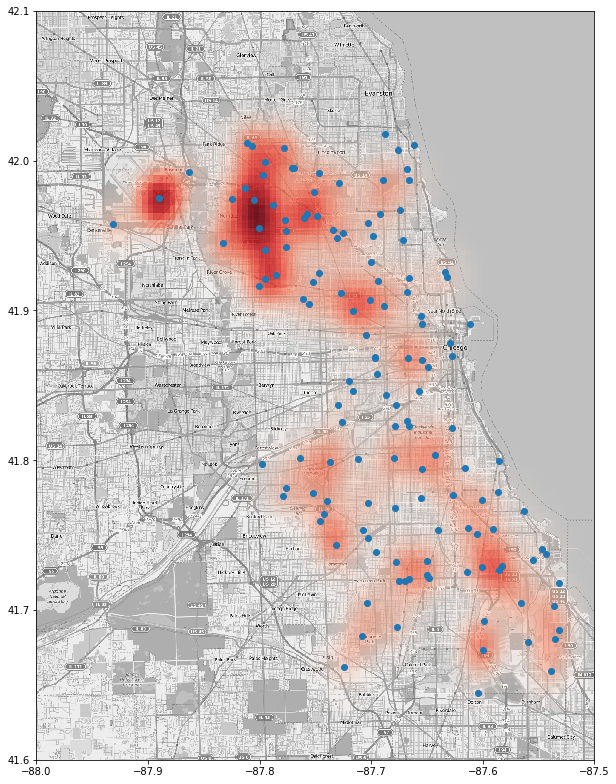

In [17]:
from sklearn.neighbors import KernelDensity

mapdata = np.loadtxt("./WNV/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('./WNV/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

sigthings = traps[traps['WnvPresent'] > 0]
sigthings = sigthings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
X = sigthings[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)
plt.imshow(zv, 
           origin='lower', 
           cmap=alpha_cm, 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1])

plt.savefig('heatmap.png')

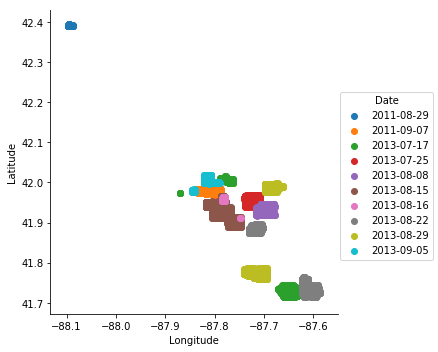

In [18]:
sns.lmplot(y='Latitude', x='Longitude', hue='Date', 
           data=df_spray, 
           fit_reg=False, scatter_kws={'alpha':1})

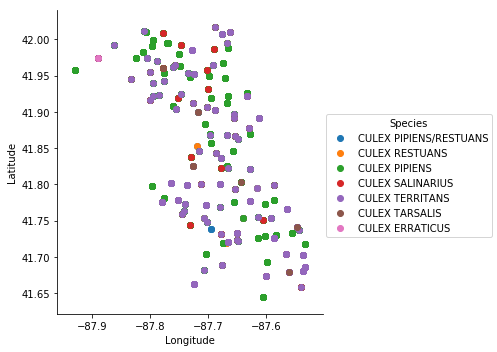

In [19]:
sns.lmplot(y='Latitude', x='Longitude', hue='Species', 
           data=df_train, 
           fit_reg=False, scatter_kws={'alpha':1})

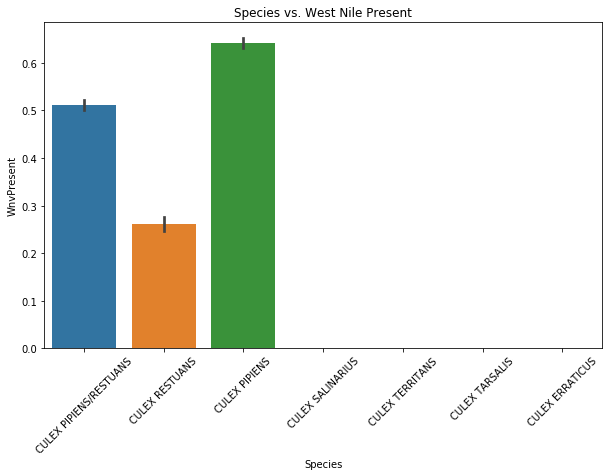

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(rotation=45) 
sns.barplot(df_train["Species"],df_train["WnvPresent"])
plt.title("Species vs. West Nile Present");

<a id='M'></a>

### Modeling:

### Best Model

In [21]:
train_dum = pd.get_dummies(df_train, drop_first=True)
test_dum = pd.get_dummies(df_test, drop_first=True)

In [22]:
dum_features = test_dum.columns.intersection(train_dum.columns)

In [30]:
X_train = train_dum[dum_features]
y_train = train_dum['WnvPresent']

logreg = LogisticRegression(penalty='l2', C=1000, random_state=42)

logreg.fit(X_train, y_train)

X_test = test_dum[dum_features]

logreg_predict_probas = logreg.predict_proba(X_test)[:,1]
train_predict_probas = logreg.predict_proba(X_train)[:,1]

df_test['WnvPresent'] = logreg_predict_probas

df_test[['Id', 'WnvPresent']].to_csv('submission_logreg', index=False)

In [31]:
roc_auc_score(y_train, train_predict_probas)

0.9050158373643089

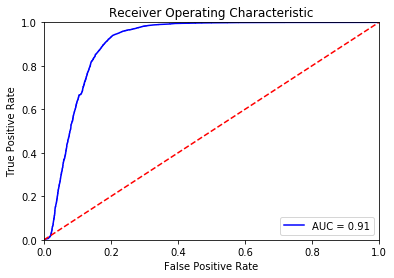

In [32]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_train, train_predict_probas)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

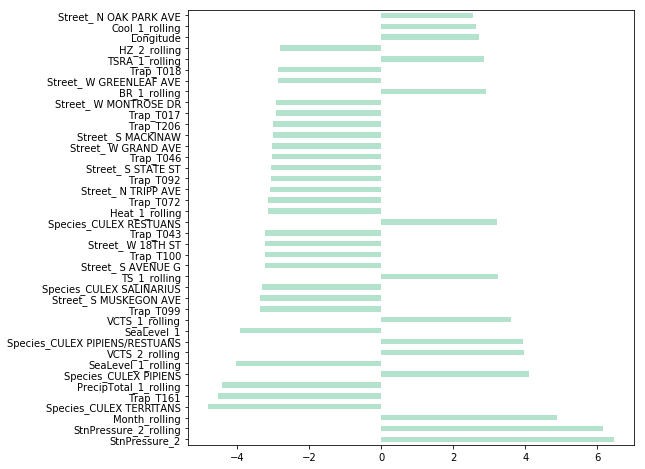

In [26]:
coefs = pd.DataFrame(logreg.coef_,columns=dum_features).T
coefs['ABS'] = coefs[0].abs()
coefs.sort_values(by='ABS', ascending=False).head(40)[0].plot(kind='barh', cmap='Pastel2', figsize=(8,8), fontsize=10);

<img src="WNV/Screen Shot 2018-09-21 at 11.02.35 AM.png" align="left">

### Other Models

In [33]:
X_train = train_dum[dum_features]
y_train = train_dum['WnvPresent']

rfc_dum = RandomForestClassifier(max_depth = 5, random_state=42)

rfc_dum.fit(X_train, y_train)

X_test = test_dum[dum_features]

rfc_dum_predict_probas = rfc_dum.predict_proba(X_test)[:,1]
train_rfc_predict_probas = rfc_dum.predict_proba(X_train)[:,1]

df_test['WnvPresent'] = rfc_dum_predict_probas

df_test[['Id', 'WnvPresent']].to_csv('submission_rfc', index=False)

In [34]:
roc_auc_score(y_train, train_rfc_predict_probas)

0.9863306640272426

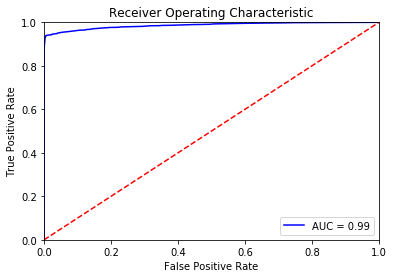

In [35]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_train, train_rfc_predict_probas)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.svm import SVC

X_train = train_dum[dum_features]
y_train = train_dum['WnvPresent']

svmc = SVC(C=.01, probability=True, random_state=42)

svmc.fit(X_train, y_train)

X_test = test_dum[dum_features]

svmc_predict_probas = svmc.predict_proba(X_test)[:,1]
train_predict_probas = svmc.predict_proba(X_train)[:,1]

df_test['WnvPresent'] = svmc_predict_probas

df_test[['Id', 'WnvPresent']].to_csv('submission_svc', index=False)

In [ ]:
roc_auc_score(y_train, train_predict_probas)

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_train, train_predict_probas)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()